In [183]:
%%capture
#%matplotlib inline
%matplotlib notebook

%load_ext autoreload
%autoreload 2

%reset -f

import os
import numpy as np

In [184]:
import pylab as plt
plt.rcParams.update({"axes.grid" : True})
plt.rcParams.update({'font.size': 12})

In [185]:
from twpazer.freader import file2dic, dic2file

In [186]:
def dump(d, Ztarget, Z, l, L, C, w, Lk, islabel=True, var ='d', varuom='nm'):
    labels = [var   , 'Z0target', 'Z0' ,   'l'   , 'L'   , 'C'   , 'Lk',      'nsq', 'Lf', 'Cf']
    units  = [varuom, '[Ohm]'   , '[Ohm]', '[um]', '[pH]', '[fF]', '[pH/sq]', ''   , 'nH', '[fF]'] 
    
    nsq = l/w     # number of square per finger
    Lf  = Lk*nsq  # finger inductance to ground (Malnou's model)
    Cf  = C/2     # finger capacitance to ground (Malnou's model)
    
    formatter=''.join(['%-11s']*len(labels))
    
    restarget=[a*b for a,b in zip([d, Ztarget, Z, l ,L, C, Lk, nsq, Lf, Cf], 
                                  [1, 1, 1, 1, 1e12, 1e15, 1e12, 1, 1e9, 1e15])]
    

    if islabel:
        print (formatter%tuple(labels))
        print (formatter%tuple(units))
        print('-' * 110)
    print (formatter%tuple(["%.2f" % i for i in restarget]))
        
    return

In [187]:
Z0fun = lambda L, C : np.sqrt(L/C)

In [188]:
def check_number(s):
    try: 
        float(s)
        return True
    except ValueError:
        return False

In [189]:
def create_path(Lk, e, d, basepath):
        
    filepath = os.path.join(basepath,    
                            'Lk{Lk}_eps{e:.1f}_d{d}'.format(Lk=Lk, e=e, d=d), 
                            'savepath')
        
    return os.path.join(filepath, [d for d in os.listdir(filepath) if 'reduced' in d][0])

In [190]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

In [191]:
def plot_frequency_trend(Lk, eps, w, s, d, basepath, savepath):
    
    
    os.makedirs(savepath) if not os.path.exists(savepath) else None

    filename = os.path.join('Lk{Lk}_eps{e:.1f}_d{d}'.format(Lk=Lk, e=eps, d=d),    
                            'savepath',                        
                            'Lk{Lk}_t10_w{w:.1f}_s{s:.1f}_d{d}_eps{e:.1f}_all_results.h5'.format(Lk=Lk,                                                                                                                                                 
                                                                                                    s=s,                                                                                                                                                                                       
                                                                                                    w=w,                                                                                                                                                                                       
                                                                                                    e=eps,                                                                                                                                                                                        
                                                                                                    d=d))
    ldata=file2dic(os.path.join(basepath, filename), writer='h5').read()
    
    
    fig, ax = plt.subplots(3,1, figsize=(8, 8))
    plt.subplots_adjust(wspace=0, hspace=0)

    ls=sorted([float(x) for x in ldata.keys() if check_number(x)])
    
    from matplotlib import cm, colors
    cmap   = plt.cm.turbo_r
    cols   = get_colors(ls, cmap,     
                        vmin=np.min(ls), vmax=np.max(ls))
    cols   = dict(zip(reversed(ls), cols))
    
    for l in ls:
    
        ax[0].plot(ldata[str(l)]['L']['freq']/1e6, ldata[str(l)]['L']['L']/1e-12,                                    
                   marker='o', ls='none', color=cols[l])
        ax[0].plot(ldata[str(l)]['L']['freq_fit']/1e6, ldata[str(l)]['L']['Lfit']/1e-12,                                     
                   color=ax[0].lines[-1].get_color())
    
        ax[1].plot(ldata[str(l)]['C']['freq']/1e6, ldata[str(l)]['C']['C']/1e-15,                                    
                   marker='o', ls='none', color=cols[l])
        ax[1].plot(ldata[str(l)]['C']['freq_fit']/1e6, ldata[str(l)]['C']['Cfit']/1e-15,                                     
                   color=ax[0].lines[-1].get_color())
    
    
        ax[2].plot(ldata[str(l)]['Z']['freq']/1e6, ldata[str(l)]['Z']['Z'],                                    
                   marker='o', ls='none', color=cols[l])
        ax[2].plot(ldata[str(l)]['Z']['freq_fit']/1e6, ldata[str(l)]['Z']['Zfit'],                                     
                   color=ax[0].lines[-1].get_color())
    
        
    #ylabels=['Inductance $\\mathcal{L}$ [pH/cell]', 'Capacitance $\\mathcal{C}$ [fF/cell]', 'Impedance $Z$ [$\\Omega$/cell]']
    ylabels=['Inductance $L$ [pH/cell]', 'Capacitance $C$ [fF/cell]', 'Impedance $Z$ [$\\Omega$/cell]']
  
    
    for i in [0,1,2]:    
         
        if i==0:
            ax[i].set_title(
            (
                r'$L_k = {Lk}\,\text{{pH/sq}},\ '
                r'w = {w}\,\mu\text{{m}},\ '
                r's = {s}\,\mu\text{{m}},\ '
                r'\varepsilon_r = {eps},\ '
                r'd = {d}\,\text{{nm}}$'
        ).format(Lk=Lk, w=w, s=s, eps=eps, d=d))
                    
        if i == 2:
            ax[i].set_xlabel('Frequency $f$ [MHz]')
    
        if i != 2:
            ax[i].tick_params('x', labelbottom=False)
        
        ax[i].set_ylabel(ylabels[i])
    
        ax[i].get_yaxis().set_label_coords(-0.075,0.5)
    

    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.15, 0.775, 0.5, 0.02])

    #cbar=m.colorbar(trend, size='3%',ticks=bounds,extend="max",location="bottom")

    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(np.min(ls),                                                 
                                                     np.max(ls)), cmap=cmap.reversed()),                  
             ax=ax[1], cax=cbar_ax, orientation="horizontal")
    
    cbar_ax.xaxis.set_ticks_position('top')
    cbar_ax.xaxis.set_label_position('top')
    cbar_ax.set_xlabel('Finger length $\ell$ [$\mu$m]')
    
    for e in ['.pdf', '.svg']:
        plt.gcf().savefig(os.path.join(savepath,'global_trend_vs_ell_and_f'+e),        
                          bbox_inches='tight', transparent=True)

### Plot as a function of the finger length for a fixed dieletric constant

In [192]:
(Lk, eps, d, w, s ) = (10, 9.6, 200, 0.5, 0.5)

basepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-DW/ellfree/analysis/d200s0.5/simdata'
savepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-DW/ellfree/analysis/d200s0.5/savedata'

os.makedirs(savepath) if not os.path.exists(savepath) else None

filename = os.path.join('Lk{Lk}_eps{e}_d{d}'.format(Lk=Lk, e=eps, d=d),
                        'savepath',
                        'Lk{Lk}_t10_w0.5_s0.5_d{d}_eps{e}_all_results.h5'.format(Lk=Lk,e=eps, d=d))


<IPython.core.display.Javascript object>


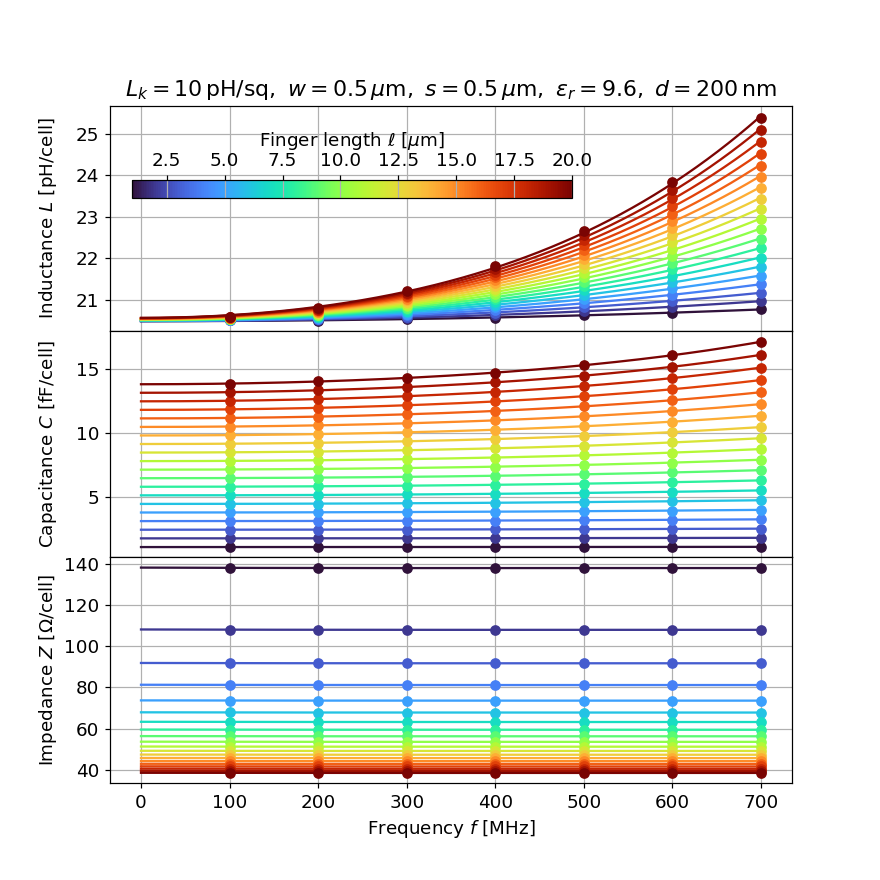

In [193]:
plot_frequency_trend(Lk, eps, w, s, d, basepath, savepath)

In [194]:
def create_path_2(Lk, e, d, basepath):
        
    filepath = os.path.join(basepath,    
                            'Lk{Lk}_eps{e:.1f}_d{d}'.format(Lk=Lk, e=e, d=d), 
                            'savepath')
        
    return os.path.join(filepath, [e for e in os.listdir(filepath) if 'reduced' in e][0])

In [195]:
def analyze_trend(eps, d, Lk, w, s, nsq, basepath, savepath, Zarget = [78, 48]):
    
    colors = ["#003049", "#d62828", "#f77f00", "#fcbf49", "#eae2b7", "#80b29a", "#264653"]
    colors = dict(zip(eps, colors[0:len(eps)]))
    
    os.makedirs(savepath) if not os.path.exists(savepath) else None
    
    
    resdata=dict()

    resdata.setdefault('data',{})

    fig, ax = plt.subplots(3,1, figsize=(8, 8))
    plt.subplots_adjust(wspace=0, hspace=0)

    for e in eps:
    
        filename = create_path_2(Lk, e, d, basepath)    
        resdata['data'].setdefault(e, {})
        resdata['data'][e] = file2dic(filename, writer='h5').read()
    
        resdata['data'][e].update({'Z'   : Z0fun(resdata['data'][e]['L'],    resdata['data'][e]['C']),                                                                                                           
                                   'Zfit': Z0fun(resdata['data'][e]['Lfit'], resdata['data'][e]['Cfit'])})
    
        ax[0].plot(resdata['data'][e]['l'], resdata['data'][e]['L']*1e12, marker = 'o', ls='none',             
                   alpha=0.7, color=colors[e])
        ax[0].plot(resdata['data'][e]['lfit'], resdata['data'][e]['Lfit']*1e12, marker = 'none', ls='-',                                    
                   color=ax[0].lines[-1].get_color())
    
        print('eps = {eps} , <L> = {L:0.2f} pH'.format(eps=e,                                              
                                               L  =np.mean(resdata['data'][e]['L'])*1e12))
    
        ax[1].plot(resdata['data'][e]['l'], resdata['data'][e]['C']*1e15, marker = 'o', ls='none',             
                   alpha=0.7, color=colors[e])    
        ax[1].plot(resdata['data'][e]['lfit'], resdata['data'][e]['Cfit']*1e15, marker = 'none', ls='-',        
                   color=ax[0].lines[-1].get_color(),
                   label='$\\varepsilon_r={e}$'.format(e=e))
    
    
        ax[2].plot(resdata['data'][e]['l'], resdata['data'][e]['Z'], marker = 'o', ls='none',             
                   alpha=0.7, color=colors[e])

        ax[2].plot(resdata['data'][e]['lfit'], resdata['data'][e]['Zfit'], marker = 'none', ls='-',                           
                   color=ax[0].lines[-1].get_color())
    
    


    ylabels=['Inductance $\\mathcal{L}$ [pH/cell]', 
             'Capacitance $\\mathcal{C}$ [fF/cell]', 
             'Impedance $Z$ [$\\Omega$/cell]']
    
    for i in [0,1,2]:        
        if i == 0: 
            pass
            #ax[i].set_title('$L_k = {Lk}$ pH/sq , $\\varepsilon = {eps}$'.format(Lk=Lk, eps=eps))
            ax[0].set_ylim([Lk*nsq-10, Lk*nsq+10])
            if i==0:ax[i].set_title(
                (r'$L_k = {Lk}\,\text{{pH/sq}},\ '
                 r'w = {w}\,\mu\text{{m}},\ '
                 r's = {s}\,\mu\text{{m}},\ '
                 r'd = {d}\,\text{{nm}}$'
                ).format(Lk=Lk, w=w, s=s, d=d))
            
        
        if i == 1: 
            ax[i].legend(loc='upper left')
        
        if i == 2:
            ax[i].set_xlabel('Finger length [$\\mu$m]')
    
        if i != 2:
            ax[i].tick_params('x', labelbottom=False)
        
        ax[i].set_ylabel(ylabels[i])
   
        ax[i].get_yaxis().set_label_coords(-0.075,0.5)
    
    

    for Z0target in Zarget:
        ax[2].axhline(y=Z0target, color='black', lw=0.9, ls='--')    
        xtext=ax[2].get_xlim()[1]-0.20*(ax[2].get_xlim()[1]-ax[2].get_xlim()[0])    
        ax[2].text(xtext, Z0target+5, r'$Z_0 = {Z}\,\Omega$'.format(Z=Z0target))
        
                
    resdata.setdefault('lbest',{})

    resdata['lbest'].update({Z: {'l': list(), 'L': list(), 'C': list(), 'Z': list(), 'e': list(),}  for Z in Zarget })   


    for e in resdata['data']: 
        for Z in Zarget:
            resdata['lbest'][Z]['e'].append(e)
            idx=np.argmin(np.abs(Z-resdata['data'][e]['Zfit']))
            resdata['lbest'][Z]['Z'].append(resdata['data'][e]['Zfit'][idx])
            resdata['lbest'][Z]['C'].append(resdata['data'][e]['Cfit'][idx])
            resdata['lbest'][Z]['L'].append(resdata['data'][e]['Lfit'][idx])
            resdata['lbest'][Z]['l'].append(resdata['data'][e]['lfit'][idx])

    for Z in Zarget:
        for x in ['e', 'Z', 'C', 'L', 'l']:
            resdata['lbest'][Z][x]=np.array(resdata['lbest'][Z][x])
            
           
        
    for Z in Zarget:
        ax[2].plot(resdata['lbest'][Z]['l'],                     
                   resdata['lbest'][Z]['Z'],                                 
                   marker='o', ls='none', color='k', zorder=100)
    
    for ee in ['.pdf', '.svg']:
        plt.gcf().savefig(os.path.join(savepath,'global_trend_ell_d{d}_Lk{Lk}_w{w}_s{s}'.format(d=d, 
                                                                                                Lk=Lk,                                                                                               
                                                                                                w=w,
                                                                                                s=s)
                                       +ee),        
                          bbox_inches='tight', transparent=True)
      
    
    islabel=True
    print('\n\n')
    for d in resdata['data']:    
        for Z in Zarget:
            idx=np.argmin(np.abs(Z-resdata['data'][d]['Zfit']))
            dump(d, Z,              
                 resdata['data'][d]['Zfit'][idx],             
                 resdata['data'][d]['lfit'][idx],                          
                 resdata['data'][d]['Lfit'][idx],                         
                 resdata['data'][d]['Cfit'][idx],              
                 w, Lk*1e-12, islabel, 
                 var ='eps', varuom=' ')
            islabel=False
    
    
    return resdata

In [200]:
def linear_response(resdata, Lk, nsq):
    fig, ax = plt.subplots(3,1, figsize=(8, 8))
    plt.subplots_adjust(wspace=0, hspace=0)

    for Z in resdata['lbest']:
        ax[0].plot(resdata['lbest'][Z]['e'], resdata['lbest'][Z]['l'], marker='o', ls='none',                                               
                   label='$Z={Z}\,\\Omega$'.format(Z=Z))
    
        p = np.poly1d(np.polyfit(resdata['lbest'][Z]['e'], resdata['lbest'][Z]['l'], 1))
        ax[0].plot(resdata['lbest'][Z]['e'], p(resdata['lbest'][Z]['e']),                                       
                   color=ax[0].lines[-1].get_color(), alpha=0.7)
        
        #print(Z,p)

        print ('Z={Z} Ohm: y = {a:0.4f}*x+{b:0.4f} '.format(Z=Z, a=p.coef[0], b=p.coef[1]))
        resdata['lbest'][Z]['pl']=[p.coef[0], p.coef[1]]
     
    
        ax[1].plot(resdata['lbest'][Z]['e'], resdata['lbest'][Z]['C']*1e15, marker='o', ls='none',                                      
                   label='$Z={Z}\,\\Omega$'.format(Z=Z))
    
        p = np.poly1d(np.polyfit(resdata['lbest'][Z]['e'], resdata['lbest'][Z]['C'], 1))
        ax[1].plot(resdata['lbest'][Z]['e'], p(resdata['lbest'][Z]['e'])*1e15,                                      
                   color=ax[1].lines[-1].get_color(), alpha=0.7)
        
        #ax[1].set_ylim([5, 30])
    
        resdata['lbest'][Z]['pC']=[p.coef[0], p.coef[1]]
    
    
        ax[2].plot(resdata['lbest'][Z]['e'], resdata['lbest'][Z]['L']*1e12, marker='o', ls='none',                                                   
                   label='$Z={Z}\,\\Omega$'.format(Z=Z))
    
        p = np.poly1d(np.polyfit(resdata['lbest'][Z]['e'], resdata['lbest'][Z]['L'], 1))
        ax[2].plot(resdata['lbest'][Z]['e'], p(resdata['lbest'][Z]['e'])*1e12,                              
                   color=ax[2].lines[-1].get_color(), alpha=0.7)
    
    
        resdata['lbest'][Z]['pL']=[p.coef[0], p.coef[1]]
    
    
    
        ylabels=['Finger length $\ell$ [$\mu$m]', 
                 'Capacitance $\\mathcal{C}$ [fF/cell]', 
                 'Inductance $\\mathcal{L}$ [pH/cell]']
    
    for i in [0,1,2]:    
    
        if i == 0:         
            #pass
            #ax[i].set_title('$L_k = {Lk}$ pH/sq , $\\varepsilon = {eps}$'.format(Lk=Lk, eps=eps))
            if i==0:ax[i].set_title(
                (r'$L_k = {Lk}\,\text{{pH/sq}},\ '
                 r'w = {w}\,\mu\text{{m}},\ '
                 r's = {s}\,\mu\text{{m}},\ '
                 r'd = {d}\,\text{{nm}}$'
                ).format(Lk=Lk, w=w, s=s, d=d))
    
        if i == 1:         
            ax[i].legend(loc='center left')
        
        if i == 2:
            ax[i].set_xlabel('Permittivity [$\\varepsilon_r$]')
            ax[i].set_ylim([Lk*nsq-10, Lk*nsq+10])
    
        if i != 2:
            ax[i].tick_params('x', labelbottom=False)
        
        ax[i].set_ylabel(ylabels[i])
   
        ax[i].get_yaxis().set_label_coords(-0.075,0.5)
    
    
    for e in ['.pdf', '.svg']:
        plt.gcf().savefig(os.path.join(savepath,'global_trend_Z_and_ell'+e),        
                          bbox_inches='tight', transparent=True)
        
    return

### Analysis as function of dieletric constant ($d=200$ nm, $w=0.5\,\mu$m, and $s=0.5\,\mu$m )

<IPython.core.display.Javascript object>


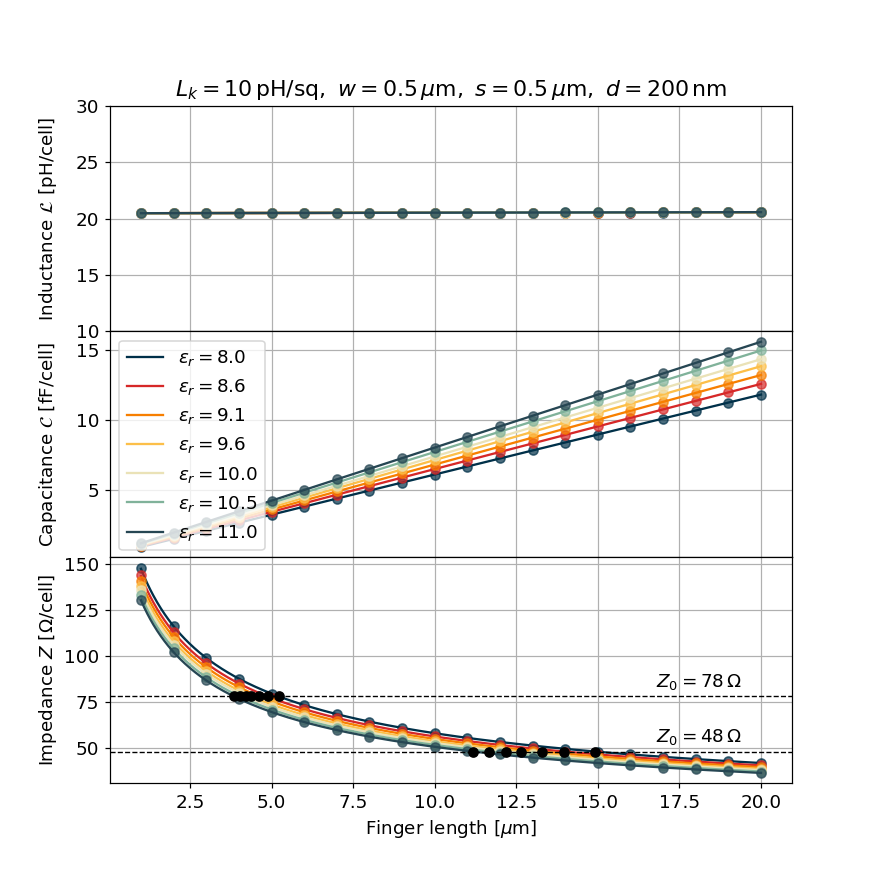

eps = 8.0 , <L> = 20.51 pH
eps = 8.6 , <L> = 20.51 pH
eps = 9.1 , <L> = 20.51 pH
eps = 9.6 , <L> = 20.51 pH
eps = 10.0 , <L> = 20.52 pH
eps = 10.5 , <L> = 20.52 pH
eps = 11.0 , <L> = 20.52 pH



eps        Z0target   Z0         l          L          C          Lk         nsq        Lf         Cf         
           [Ohm]      [Ohm]      [um]       [pH]       [fF]       [pH/sq]               nH         [fF]       
--------------------------------------------------------------------------------------------------------------
8.00       78.00      78.01      5.22       20.49      3.37       10.00      10.44      0.10       1.68       
8.00       48.00      48.00      14.92      20.52      8.91       10.00      29.84      0.30       4.45       
8.60       78.00      77.99      4.88       20.49      3.37       10.00      9.76       0.10       1.68       
8.60       48.00      48.01      13.97      20.52      8.90       10.00      27.94      0.28       4.45       
9.10       78.00      78.07 

In [201]:
basepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-DW/ellfree/analysis/d200s0.5/simdata'
savepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-DW/ellfree/analysis/d200s0.5/savedata'

os.makedirs(savepath) if not os.path.exists(savepath) else None

eps  = [8.0, 8.6, 9.1, 9.6, 10.0, 10.5, 11.0]
(d, Lk, w, s, nsq) = (200, 10, 0.5, 0.5, 2)
resdata=analyze_trend(eps, d, Lk, w, s, nsq, basepath, savepath)

<IPython.core.display.Javascript object>


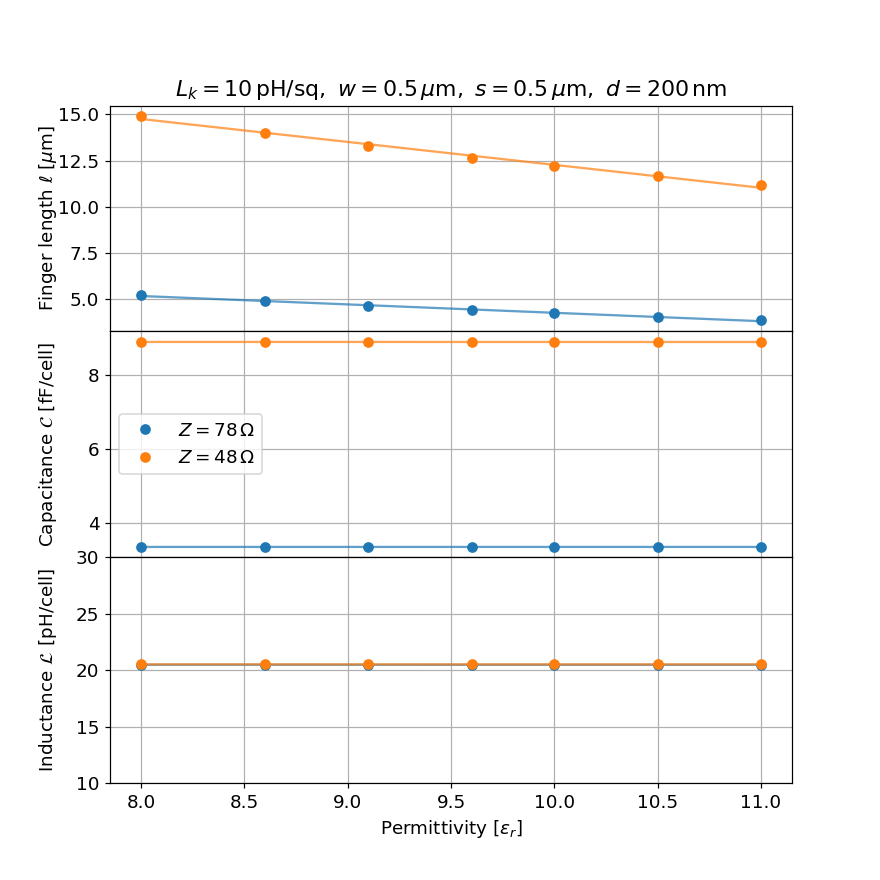

Z=78 Ohm: y = -0.4553*x+8.8012 
Z=48 Ohm: y = -1.2432*x+24.6993 


In [202]:
linear_response(resdata, Lk, nsq)

### Analysis as function of dieletric constant ($d=200$ nm, $w=0.5\,\mu$m, and $s=1\,\mu$m )

<IPython.core.display.Javascript object>


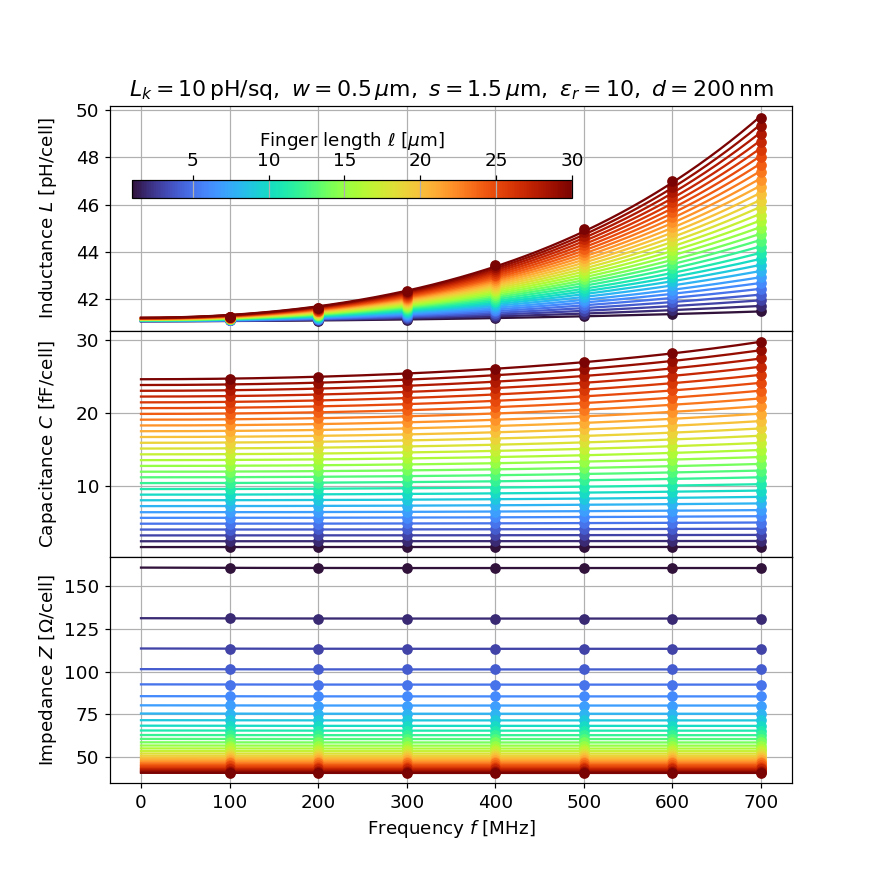

In [203]:
basepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-DW/ellfree/analysis/d200s1.0/simdata'
savepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-DW/ellfree/analysis/d200s1.0/savedata'

os.makedirs(savepath) if not os.path.exists(savepath) else None

eps  = [8.0, 9.0, 10, 11]
(d, Lk, w, s, nsq) = (200, 10, 0.5, 1.5, 4)

plot_frequency_trend(Lk, 10, w, s, d, basepath, savepath)

<IPython.core.display.Javascript object>


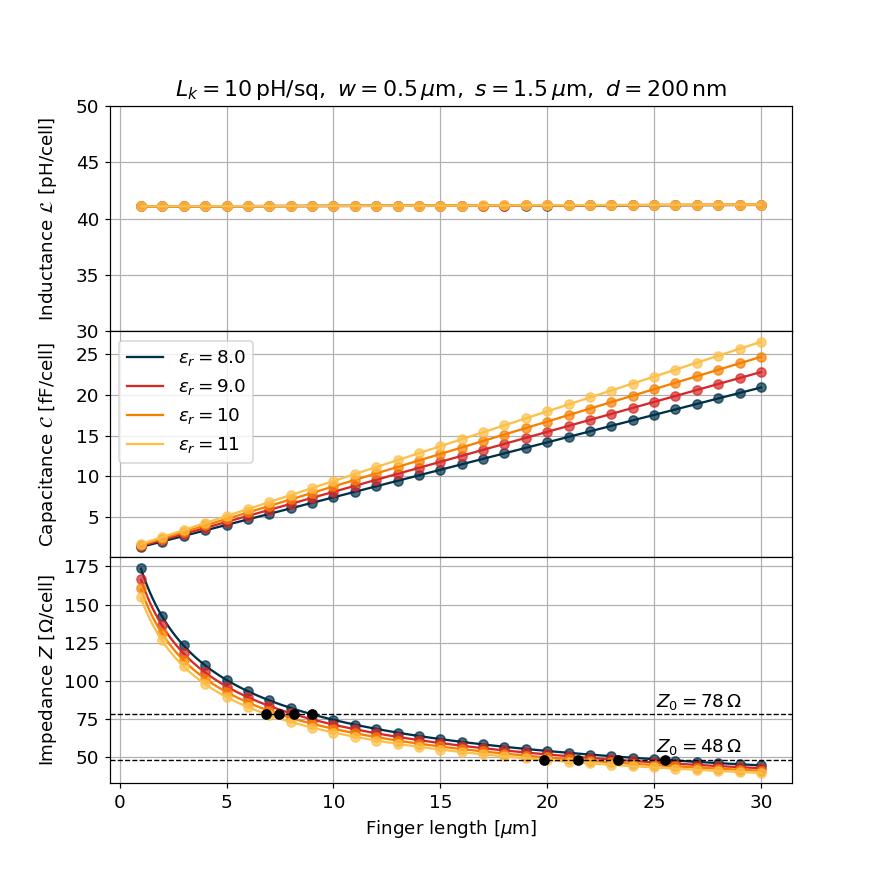

eps = 8.0 , <L> = 41.14 pH
eps = 9.0 , <L> = 41.14 pH
eps = 10 , <L> = 41.15 pH
eps = 11 , <L> = 41.15 pH



eps        Z0target   Z0         l          L          C          Lk         nsq        Lf         Cf         
           [Ohm]      [Ohm]      [um]       [pH]       [fF]       [pH/sq]               nH         [fF]       
--------------------------------------------------------------------------------------------------------------
8.00       78.00      77.98      8.98       41.11      6.76       10.00      17.97      0.18       3.38       
8.00       48.00      47.99      25.50      41.18      17.88      10.00      51.00      0.51       8.94       
9.00       78.00      78.03      8.14       41.10      6.75       10.00      16.28      0.16       3.38       
9.00       48.00      47.99      23.29      41.18      17.88      10.00      46.59      0.47       8.94       
10.00      78.00      78.05      7.44       41.10      6.75       10.00      14.89      0.15       3.37       
10.

In [204]:
resdata=analyze_trend(eps, d, Lk, w, s, nsq, basepath, savepath)

<IPython.core.display.Javascript object>


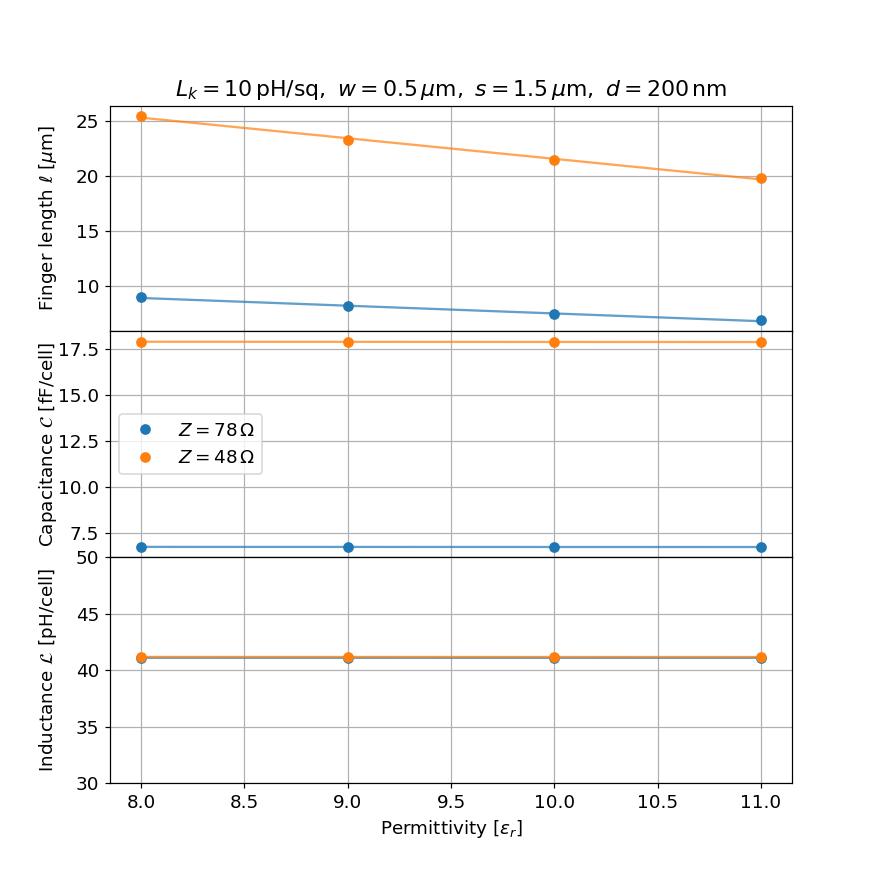

Z=78 Ohm: y = -0.7054*x+14.5595 
Z=48 Ohm: y = -1.8753*x+40.3401 


In [205]:
linear_response(resdata, Lk, nsq)

In [206]:
Nu=30;   Nl=4
Lu=60.6/1e12; Ll=60.6/1e12
Cu=26.4/1e15; Cl=10.0/1e15; 

In [89]:
Zeff=np.sqrt( (Nu*Lu+Nl*Ll)/(Nu*Cu+Nl*Cl) )

In [90]:
def compute_Zeff(Nu, Lu, Cu, Nl, Ll, Cl):
    
    return np.sqrt( (Nu*Lu+Nl*Ll) / (Nu*Cu+Nl*Cl)   )

In [91]:
Lk=10; eps=10


Zu=np.min(list(resdata['lbest']))
Zl=np.max(list(resdata['lbest']))

for e in list(resdata['lbest'][Zu]['e']):
    idx=list(resdata['lbest'][Zu]['e']).index(e)
    Cu=resdata['lbest'][Zu]['C'][idx]
    Cl=resdata['lbest'][Zl]['C'][idx]
    Lu=resdata['lbest'][Zu]['L'][idx]
    Ll=resdata['lbest'][Zl]['L'][idx]

    print(compute_Zeff(Nu, Lu, Cu, Nl, Ll, Cl))

49.84221659970231
49.84056161882949
49.85624079887727
49.858238144570805


In [92]:
compute_Zeff(Nu, Lu, Cu, Nl, Ll, Cl)

49.858238144570805

## d = 100nm vs d=200nm

In [93]:
data100nm = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-DW/ellfree/analysis/d200s0.5/simdata/Lk10_eps9.1_d100/savepath/Lk10_t10_w0.5_s0.5_d100_eps9.1_reduced.h5'
data200nm = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-DW/ellfree/analysis/d200s0.5/simdata/Lk10_eps9.1_d200/savepath/Lk10_t10_w0.5_s0.5_d200_eps9.1_reduced.h5'

datafile=[data100nm, data200nm]

colors = ["#003049", "#d62828", "#f77f00", "#fcbf49", "#eae2b7", "#80b29a", "#264653"]

<IPython.core.display.Javascript object>


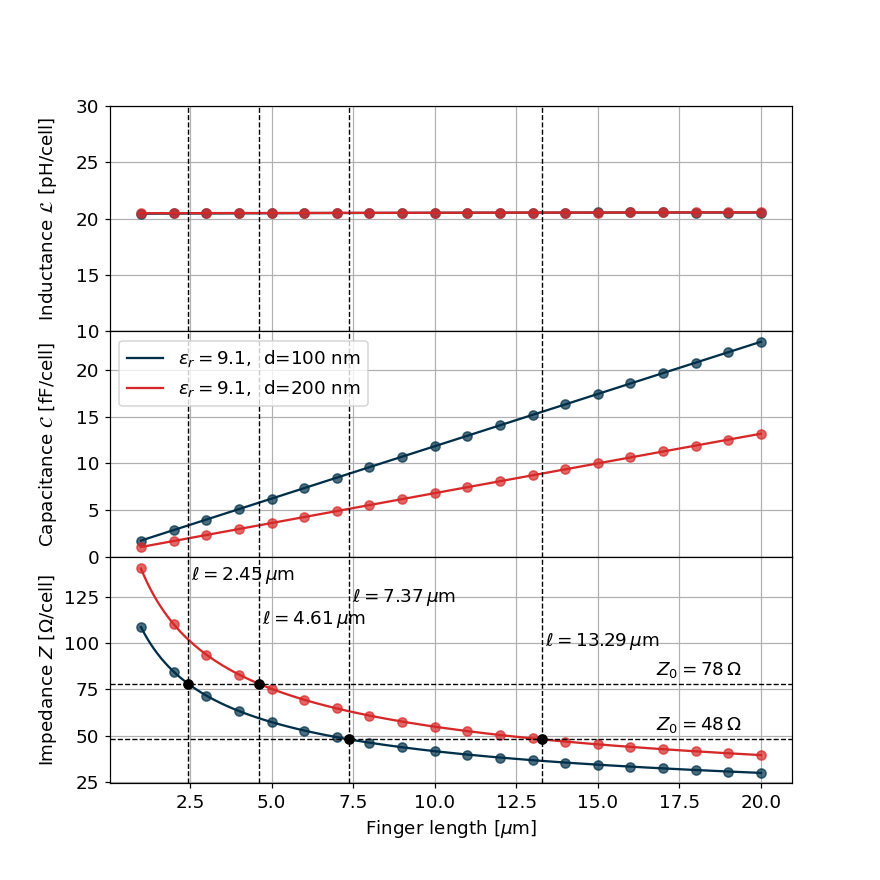

In [94]:
fig, ax = plt.subplots(3,1, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)

cfg = {data100nm: {'d': 100, 'eps': 9.1, 'color': colors[0] },
       data200nm: {'d': 200, 'eps': 9.1, 'color': colors[1] }}

for filename in datafile:

    data = file2dic(filename, writer='h5').read()
    
    data.update({'Z'   : Z0fun(data['L'],    data['C']),                                                                                                           
                 'Zfit': Z0fun(data['Lfit'], data['Cfit'])})
    
    ax[0].plot(data['l'], data['L']*1e12, marker = 'o', ls='none',     
                 alpha=0.7, color=cfg[filename]['color'])
    ax[0].plot(data['lfit'], data['Lfit']*1e12, marker = 'none', ls='-',                   
                 color=ax[0].lines[-1].get_color())
    ax[0].set_ylim([10, 30])
    
    
    ax[1].plot(data['l'], data['C']*1e15, marker = 'o', ls='none',     
                 alpha=0.7, color=cfg[filename]['color'])
    ax[1].plot(data['lfit'], data['Cfit']*1e15, marker = 'none', ls='-',
               color=ax[0].lines[-1].get_color(),
               label='$\\varepsilon_r={e}$,  d={d} nm'.format(e=cfg[filename]['eps'],                                                              
                                                              d=cfg[filename]['d']))
    
    
    ax[2].plot(data['l'], data['Z'], marker = 'o', ls='none',     
                 alpha=0.7, color=cfg[filename]['color'])
    ax[2].plot(data['lfit'], data['Zfit'], marker = 'none', ls='-',                   
                 color=ax[0].lines[-1].get_color())
    
    
ylabels=['Inductance $\\mathcal{L}$ [pH/cell]', 'Capacitance $\\mathcal{C}$ [fF/cell]', 'Impedance $Z$ [$\\Omega$/cell]']
    
for i in [0,1,2]:    
    
    if i == 0: 
        pass
        #ax[i].set_title('$L_k = {Lk}$ pH/sq , $\\varepsilon = {eps}$'.format(Lk=Lk, eps=eps))
    
    if i == 1: 
        ax[i].legend(loc='upper left')
        
    if i == 2:
        ax[i].set_xlabel('Finger length [$\\mu$m]')
    
    if i != 2:
        ax[i].tick_params('x', labelbottom=False)
        
    ax[i].set_ylabel(ylabels[i])
   
    ax[i].get_yaxis().set_label_coords(-0.075,0.5)

    
Zarget = [78, 48]
for Z0target in Zarget:
    ax[2].axhline(y=Z0target, color='black', lw=0.9, ls='--')    
        
    xtext=ax[2].get_xlim()[1]-0.20*(ax[2].get_xlim()[1]-ax[2].get_xlim()[0])    
    ax[2].text(xtext, Z0target+5, r'$Z_0 = {Z}\,\Omega$'.format(Z=Z0target))
    

Zarget = [78, 48]
offset=0
for filename in datafile: 
    for Z in Zarget:
        data = file2dic(filename, writer='h5').read()    
        data.update({'Z'   : Z0fun(data['L'],    data['C']),                                                                                                                   
                     'Zfit': Z0fun(data['Lfit'], data['Cfit'])})
        idx=np.argmin(np.abs(Z-data['Zfit']))
        
        ax[2].plot(data['lfit'][idx],                            
                   data['Zfit'][idx],                                 
                   marker='o', ls='none', color='k', zorder=100)
        
        for ii in [0,1,2]:
            ax[ii].axvline(x=data['lfit'][idx], color='black', lw=0.9, ls='--') 
            
        ytext=ax[2].get_ylim()[1]-0.10*(ax[2].get_ylim()[1]-ax[2].get_ylim()[0])    
        
        ax[2].text(data['lfit'][idx]+0.1, ytext-offset, r'$\ell = {l:0.2f}\,\mu$m'.format(l=data['lfit'][idx]))
        offset += 12
        
for ee in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(savepath,'global_trend_ell_100nmVs200nm'+ee),
                      bbox_inches='tight', transparent=True)

In [ ]:
data = file2dic(filename, writer='h5').read()

In [ ]:
data.keys()